In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from glob import glob
import cv2
from matplotlib import animation
from IPython import display


In [2]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype
        pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift

    intercept = float(dcm.RescaleIntercept) if hasattr(dcm, "RescaleIntercept") else 0
    slope = float(dcm.RescaleSlope) if hasattr(dcm, "RescaleSlope") else 1
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2

    pixel_array = (pixel_array * slope) + intercept
    pixel_array = np.clip(pixel_array, low, high)
    return pixel_array

In [3]:
train_descriptions = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
train_coord_df = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")
train_coord_df = train_coord_df.merge(train_descriptions, on=["series_id", "study_id"], how="left")
train_df = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train.csv")

In [40]:
planes = {"sagittal": 0, "coronal": 1, "axial": 2}
series_ids = train_coord_df[train_coord_df.series_description == "Axial T2"].series_id.unique()
dcm_paths = glob(f"../../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/**/{series_ids[0]}/**/*.dcm", recursive=True) 
pydicom.dcmread(dcm_paths[0]).ImagePositionPatient[2]
dicoms = [pydicom.dcmread(f) for f in dcm_paths]
positions = np.asarray([float(d.ImagePositionPatient[2]) for d in dicoms])
idx = np.argsort(-positions)
np.asarray(dcm_paths)[idx]
np.asarray([d.ImageOrientationPatient for d in dicoms])[idx]
dicoms[0].PixelSpacing

[0.625, 0.625]

In [28]:
study_num = []
dirs = glob("../../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/*")
for d in dirs:
    study_num.append(len(glob(d + "/*")))

(array([   0.,    3., 1632.,  309.,   30.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <BarContainer object of 5 artists>)

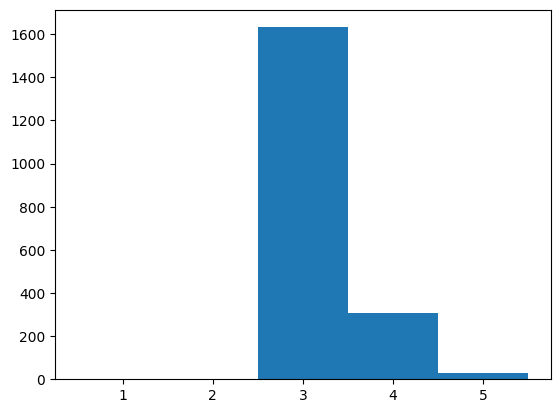

In [36]:
plt.hist(study_num, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5])